In [56]:
# Major imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn

# Model creation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [57]:
# Paths for data
train_path = os.path.join('data', 'train.csv')
test_path = os.path.join('data', 'test.csv')
submission_path = os.path.join('data','sample_submission.csv')

# Load data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

### Exploratory Data Analysis

In [58]:
# Explore dataset
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [59]:
def df_summary(dataframe):
    # To get summary about the dataset
    # Returns dataframe containing summary of the dataset
    nn_counts = dataframe.count()
    datatypes = dataframe.dtypes
    n_counts = dataframe.isnull().sum()
    unique_counts = dataframe.nunique()

    summary = pd.DataFrame(
        {
            'datatype': datatypes,
            'nonnull': nn_counts,
            'null': n_counts,
            'unique': unique_counts
        }
    )

    return summary

In [60]:
# Get summary of the dataset
train_summary = df_summary(train)
train_summary

,datatype,nonnull,null,unique
id,int64,20758,0,20758
Gender,object,20758,0,2
Age,float64,20758,0,1703
Height,float64,20758,0,1833
Weight,float64,20758,0,1979
family_history_with_overweight,object,20758,0,2
FAVC,object,20758,0,2
FCVC,float64,20758,0,934
NCP,float64,20758,0,689
CAEC,object,20758,0,4


In [61]:
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


### Data Cleaning

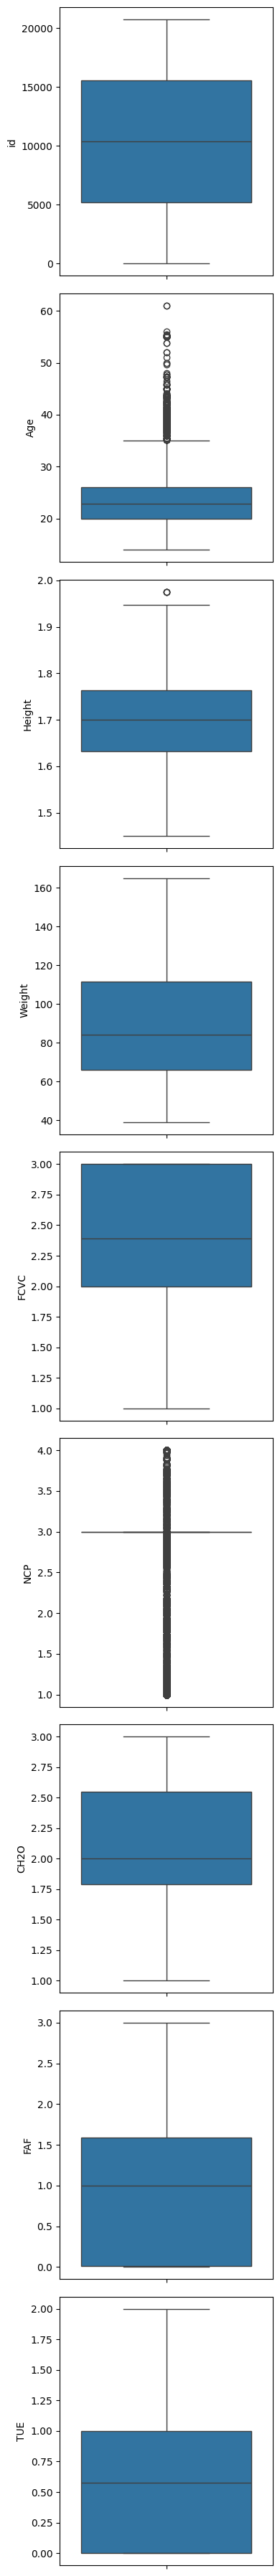

In [62]:
# numerical column extraction
num_cols = [col for col in train.columns if train[col].dtype != 'object']

num_cols_count = len(num_cols)

# Distribution of numerical columns
fig, axes = plt.subplots(num_cols_count, 1, figsize=(4, 4*num_cols_count))

for i, col in enumerate(num_cols):
    sns.boxplot(train[col], ax=axes[i])

plt.tight_layout()
plt.show()


Age contains numerous outliers as evidenced by the boxplot. Removing the outliers should ideally help us improve the accuracy of our model.

Typical definiton of an outlier in a distribution in LaTex format is given by:
- $x < Q1 - 1.5 \times IQR$
- $x > Q3 + 1.5 \times IQR$

where $Q1$ is the first quartile, $Q3$ is the third quartile and $IQR$ is the interquartile range.


In [63]:
def remove_outliers(dataframe, column):
    # Removes outliers from the dataframe
    # Returns dataframe without outliers
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataframe = dataframe[(dataframe[column] > lower_bound) & (dataframe[column] < upper_bound)]

    return dataframe

In [64]:
train = remove_outliers(train, 'Age')

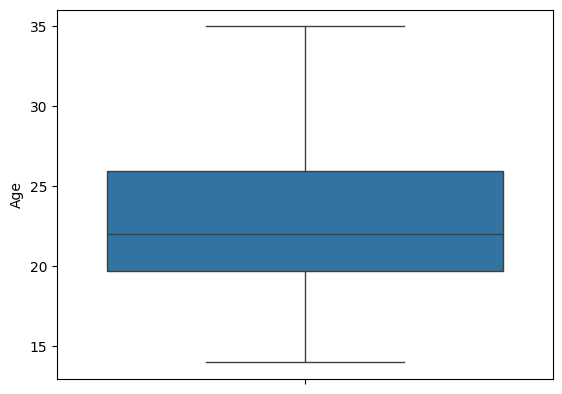

In [65]:
# Age after outlier removal
sns.boxplot(train['Age'])
plt.show()

As is evidenced by the boxplot, Age is now almost normally distributed after removing outliers.

### Data Visualization

In [66]:
# Creating copy for visualisation purposes
train_vis = train.copy()

In [67]:
# BMI calculation
train_vis['BMI'] = train_vis['Weight'] / (train_vis['Height']) ** 2

In [68]:
# Grouped means for BMI

def grouped_means(dataframe, group_col, mean_col):
    # Returns grouped means for the dataframe
    grouped_means = dataframe.groupby(group_col)[mean_col].mean().reset_index()

    return grouped_means

# Grouped means for BMI
bmi_vs_gender = grouped_means(train_vis, "Gender", "BMI")

In [69]:
bmi_vs_gender

,Gender,BMI
0,Female,31.053531
1,Male,29.328167


Females are predicted to have a higher BMI than males as evidenced by the distribution given by the dataset.

In [70]:
age_vs_obesity_category = grouped_means(train_vis, "NObeyesdad", "Age")

In [71]:
age_vs_obesity_category.sort_values(by='Age', ascending=False)

,NObeyesdad,Age
3,Obesity_Type_II,27.036316
6,Overweight_Level_II,24.338175
4,Obesity_Type_III,24.126847
2,Obesity_Type_I,22.078171
5,Overweight_Level_I,21.879644
1,Normal_Weight,20.652192
0,Insufficient_Weight,19.281458


The dataset provides a clear indication that the relationship between obesity and age is somewhat linear. As age increases, the level of obesity of the individual also tends to increase. This can be due to factors such as increase in body fat percentage, decrease in muscle mass, and decrease in metabolic rate.

### Preprocessing

In [72]:
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

In [73]:
# Split columns in X into categorical and numerical
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
num_cols = [col for col in X.columns if X[col].dtype != 'object']

# Defining preprocessing steps
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Creation

Predicting the obesity level of an individual based on the given features is a classification problem. We will use an ensemble of a Random Forest Classifier and a Support Vector Classifier to predict the obesity level of an individual based on the given features.

Reasons for choosing Random Forest Classifier:
- Random Forest Classifier is an ensemble method that is robust to overfitting.
- Random Forest Classifier is able to handle large datasets with higher dimensionality.

Reasons for choosing Support Vector Classifier:
- Support Vector Classifier is able to handle non-linear data.
- Support Vector Classifier is able to handle outliers well.

In [74]:
# Pipeline definition
def model_pipeline(preprocessing, model):
    # Returns model pipeline
    model_pipeline = make_pipeline(preprocessor, model)

    return model_pipeline

In [75]:
# Define two pipelines for Random Forest and SVM
rf_pipeline = model_pipeline(preprocessor, RandomForestClassifier())
svm_pipeline = model_pipeline(preprocessor, SVC())

In [76]:
# GridSearchCV creation
def create_gridsearch(pipeline, param_grid, cv):

    # Returns GridSearchCV object
    gridsearch = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        scoring=['accuracy', 'f1_macro'],
        refit='accuracy',
    )

    return gridsearch

Handling the GridSearch:

In [77]:
# Random Forest parameter grid
rf_param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_depth': [10, 20, 30, 40, 50],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__bootstrap': [True, False]
}

# SVM parameter grid
svm_param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']
}

In [78]:
def get_best_model(X_train, y_train):
    # Returns best ensemble model
    rf_gridsearch = create_gridsearch(rf_pipeline, rf_param_grid, 5)
    rf_gridsearch.fit(X_train, y_train)

    svm_gridsearch = create_gridsearch(svm_pipeline, svm_param_grid, 5)
    svm_gridsearch.fit(X_train, y_train)

    if rf_gridsearch.best_score_ > svm_gridsearch.best_score_:
        best_model = rf_gridsearch.best_estimator_
        best_params = rf_gridsearch.best_params_
        best_score = rf_gridsearch.best_score_
    else:
        best_model = svm_gridsearch.best_estimator_
        best_params = svm_gridsearch.best_params_
        best_score = svm_gridsearch.best_score_

    return best_model, best_params, best_score

In [79]:
# Best model and metrics
best_model, best_params, best_score = get_best_model(X_train, y_train)

In [80]:
# Defining training results
def training_results(model, X_train, y_train):
    # Returns training results
    print(model)
    print("Best params: ", model.get_params())
    print("Accuracy: ", cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean())

# Training results
training_results(best_model, X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['id', 'Age', 'Height',
                                                   'Weight', 'FCVC', 'NCP',
                                                   'CH2O', 'FAF', 'TUE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=20,
                                        min_sam

In [81]:
# Test set predictions
def test_predictions(model, X_test, y_test):
    # Returns test set predictions
    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Classification report: ", classification_report(y_test, y_pred))
    print("Confusion matrix: ", confusion_matrix(y_test, y_pred))

# Test set predictions
test_predictions(best_model, X_test, y_test)

Accuracy:  0.8992622742304757
Classification report:                       precision    recall  f1-score   support

Insufficient_Weight       0.91      0.93      0.92       503
      Normal_Weight       0.83      0.88      0.85       611
     Obesity_Type_I       0.92      0.87      0.90       483
    Obesity_Type_II       0.96      0.98      0.97       613
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.81      0.70      0.75       454
Overweight_Level_II       0.80      0.83      0.81       458

           accuracy                           0.90      3931
          macro avg       0.89      0.89      0.89      3931
       weighted avg       0.90      0.90      0.90      3931

Confusion matrix:  [[469  31   0   1   0   1   1]
 [ 42 537   0   0   0  28   4]
 [  1   0 421  19   3  10  29]
 [  0   0   8 603   0   0   2]
 [  0   1   1   1 806   0   0]
 [  5  66   4   0   0 319  60]
 [  1  14  23   2   0  38 380]]


In [85]:
# Actual outputs of predictions for competition
ypred_test = best_model.predict(test)

submission_df = pd.DataFrame(
    {
        'id': test['id'],
        'NObeyesdad': ypred_test
    }
)

submission_df.to_csv('data/submission.csv', index=False)

submission_df.shape


(13840, 2)